In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Subset, random_split
import torch.optim as optim

from torchsummary import summary
import random
import numpy as np
import matplotlib.pyplot as plt
import time

from tqdm import tqdm



# ConvNet for MNIST

In [11]:

# Torch/PIL transformations which are applied to each image in the dataset
transform = transforms.Compose([transforms.ToTensor(),
                              ])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.08MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 130kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]


## Get Normalization Values

In [12]:
# Function to get the first N items from the dataset
def get_first_n_items_as_numpy(dataset, n):
    # Create a subset of the dataset containing the first N items
    subset = torch.utils.data.Subset(dataset, list(range(n)))

    # Initialize lists to store images and labels
    images = []
    labels = []

    # Iterate through the subset and convert each item to numpy array
    for image, label in subset:
        images.append(image.numpy())
        labels.append(label)

    # Convert lists to numpy arrays
    images_np = np.array(images)
    labels_np = np.array(labels)

    return images_np, labels_np

In [13]:


# Example: Get the first 5000 items from the MNIST dataset as numpy arrays
n = 5000
images_np, labels_np = get_first_n_items_as_numpy(trainset, n)

# Print the shapes of the numpy arrays
print(f"Images shape: {images_np.shape}")
print(f"Labels shape: {labels_np.shape}")
print(f"MNIST subset mean and std:", images_np.mean(), images_np.std())
mnist_mean, mnist_std  = images_np.mean(), images_np.std()

Images shape: (5000, 1, 28, 28)
Labels shape: (5000,)
MNIST subset mean and std: 0.13022237 0.3075404


# Prepate data
## Re-init dataset with correct values, data splits

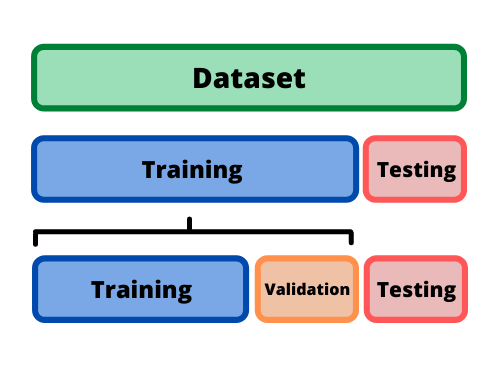

In [14]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mnist_mean, mnist_std)
])

train_batch_size = 512
test_batch_size = 2048

# Load the full MNIST training dataset
trainset = torchvision.datasets.MNIST(
    root='./data', train=True, download=True, transform=transform)

# Sample 20% of the training dataset
total_train_samples = len(trainset)
sample_size = int(0.2 * total_train_samples)  # 20% of the dataset

# For reproducibility
np.random.seed(42)
indices = np.random.permutation(total_train_samples)[:sample_size]

# Create a subset of the dataset with the sampled indices
sampled_trainset = Subset(trainset, indices)

# Split the sampled dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * sample_size)
val_size = sample_size - train_size
train_subset, val_subset = random_split(
    sampled_trainset,
    [train_size, val_size]
    )

# Create dataloaders for the training and validation sets
train_loader = DataLoader(
    train_subset, batch_size=train_batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(
    val_subset, batch_size=train_batch_size, shuffle=False, num_workers=2)

# Load the full MNIST test dataset
testset = torchvision.datasets.MNIST(
    root='./data', train=False, download=True, transform=transform)

# Create a dataloader for the test set
test_loader = DataLoader(
    testset, batch_size=test_batch_size, shuffle=False, num_workers=2)


In [15]:
# Lets check out the values after normalization
images_np, labels_np = get_first_n_items_as_numpy(trainset, n)
print(f"After normaliztion: mean and std:", images_np.mean(), images_np.std())
# Lets print the datasets sizes
print("Train set size:", train_size)
print("Validation set size:", val_size)
print("Test set size:", len(testset))


After normaliztion: mean and std: -2.1159892e-08 0.99999994
Train set size: 9600
Validation set size: 2400
Test set size: 10000


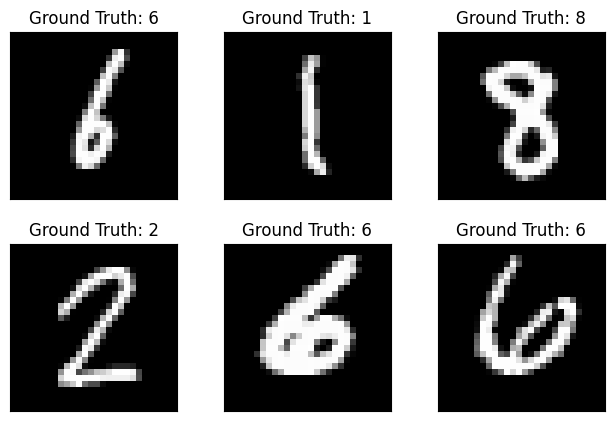

In [16]:

# enumerate - get index as well
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

## Training procedure

In [17]:
def plot_training_results(results_dict):
    """
    Plots the training and validation loss and accuracy stored in results_dict.

    Parameters:
    - results_dict: Dictionary containing training and validation loss and accuracy per epoch.
    """
    epochs = range(1, len(results_dict['train_loss']) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, results_dict['train_loss'], label='Training Loss')
    plt.plot(epochs, results_dict['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs. Validation Loss')
    plt.legend()
    plt.grid()
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, results_dict['train_acc'], label='Training Accuracy')
    plt.plot(epochs, results_dict['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs. Validation Accuracy')
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [18]:
def train_model(model, optimizer, train_loader, val_loader, num_epochs, criterion, device=None):
    """
    Trains the model and returns a results dictionary containing loss and accuracy per epoch.

    Parameters:
    - model: The neural network model to train.
    - optimizer: The optimizer for updating model weights.
    - train_loader: DataLoader for the training dataset.
    - val_loader: DataLoader for the validation dataset.
    - num_epochs: Number of epochs to train.
    - criterion: Loss function (default is CrossEntropyLoss).
    - device: The device to run on (CPU or CUDA).

    Returns:
    - results_dict: Dictionary containing training and validation loss and accuracy per epoch.
    """

    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)

    results_dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    since = time.time()

    for epoch in tqdm(range(num_epochs), desc="Training model"):

        # Each epoch has a training and a validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
            else:
                model.eval()   # Set model to evaluation mode
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            total_samples = 0

            # Iterate over data
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward pass and track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    # max, arg_max
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                total_samples += labels.size(0)

            epoch_loss = running_loss / total_samples
            epoch_acc = running_corrects.double() / total_samples

            results_dict[f'{phase}_loss'].append(epoch_loss)
            results_dict[f'{phase}_acc'].append(epoch_acc.item())


    time_elapsed = time.time() - since
    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

    return results_dict

# Models
## MLP

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# The long but more organized way (for very large architectures)
class MLP(nn.Module):
    def __init__(self, input_size=28*28, output_size=10, hidden_sizes=[64,128]):
      super(MLP, self).__init__()
      self.input = nn.Linear(input_size, hidden_sizes[0])
      self.hidden1 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
      self.hidden2 = nn.Linear(hidden_sizes[1], output_size)

    # x represents our data
    def forward(self, x):
      x = self.input(x)
      x = F.relu(x)
      x = self.hidden1(x)
      x = F.relu(x)
      # sometimes refered to as 'logits'
      x = self.hidden2(x)
      output = F.log_softmax(x, dim=1)
      return output


In [20]:
input_size = 28*28
output_size = 10
hidden_sizes=[128,128]
mlp_model = MLP(input_size, output_size, hidden_sizes)

summary(mlp_model, input_size=(1, input_size), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]         100,480
            Linear-2               [-1, 1, 128]          16,512
            Linear-3                [-1, 1, 10]           1,290
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.45
Estimated Total Size (MB): 0.46
----------------------------------------------------------------


# Convolutional Neural Network (CNN)

### The convolution operation

![image.png](https://miro.medium.com/max/1070/1*Zx-ZMLKab7VOCQTxdZ1OAw.gif)

## Input and Output Dimensions
#### Convolution (Conv2d)
\begin{align}
H_{out} = \left\lfloor \frac{H_{in} + 2 \times \text{padding} - \text{dilation} \times (\text{kernel_size} - 1) - 1}{\text{stride}} + 1 \right\rfloor
\end{align}
\begin{align}
W_{out} = \left\lfloor \frac{W_{in} + 2 \times \text{padding} - \text{dilation} \times (\text{kernel_size} - 1) - 1}{\text{stride}} + 1 \right\rfloor
\end{align}

#### Transposed Convolution (ConvTranspose2d)
\begin{aligned}
 H_{out} = (\text{stride} \times (H_{in} - 1) + \text{kernel_size} - 2 \times \text{padding} + \text{output_padding})
\end{aligned}

\begin{aligned}
 W_{out} = (\text{stride} \times (W_{in} - 1) + \text{kernel_size} - 2 \times \text{padding} + \text{output_padding})
\end{aligned}

## Edge Detection with Sobel Filter

In [21]:
# define edge detector kernels
sobel_kernel_x = torch.tensor([[ -1.,  0.,  1.],
                               [ -2.,  0.,  2.],
                               [ -1.,  0.,  1.]])

sobel_kernel_y = torch.tensor([[ -1., -2., -1.],
                               [  0.,  0.,  0.],
                               [  1.,  2.,  1.]])

# Reshape kernels to match the expected shape: [out_channels, in_channels/groups, kH, kW]
sobel_kernel_x = sobel_kernel_x.view(1, 1, 3, 3)
sobel_kernel_y = sobel_kernel_y.view(1, 1, 3, 3)

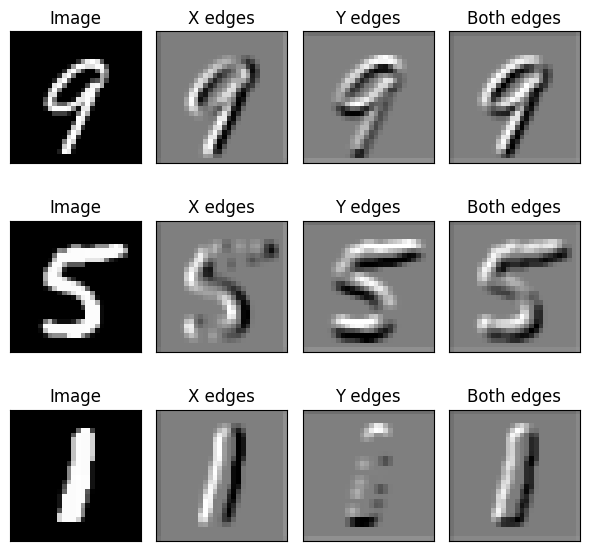

In [22]:
images ,labesl = next(iter(train_loader))


# Apply the Sobel kernels using F.conv2d
edge_x = F.conv2d(images, sobel_kernel_x, padding=1)
edge_y = F.conv2d(images, sobel_kernel_y, padding=1)
edge_xy = edge_x + edge_y
fig, axes = plt.subplots(3,4, figsize=(6,6), dpi=100)
#axes = axes.ravel()

# iter of rows
for j, ax in enumerate(axes):
  ax[0].imshow(images[j].squeeze(), cmap='gray')
  ax[0].set_title("Image")
  ax[1].imshow(edge_x[j].squeeze(), cmap='gray')
  ax[1].set_title("X edges")
  ax[2].imshow(edge_y[j].squeeze(), cmap='gray')
  ax[2].set_title("Y edges")

  ax[3].imshow(edge_xy[j].squeeze(), cmap='gray')
  ax[3].set_title("Both edges")
  for i in range(4):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout()
plt.show()

In [26]:
class CNN(nn.Module):
    def __init__(self, in_channels=1, num_classes=10, num_filters=[64, 128], input_dims=(1,28,28)):
        super(CNN, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=num_filters[0],  # 32
            kernel_size=3, stride=1, padding="same"
        )

        self.conv2 = nn.Conv2d(
            in_channels=num_filters[0],   # 32
            out_channels=num_filters[1],  # 16
            kernel_size=3, stride=1, padding=1
        )

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Compute the flatten dimension dynamically
        self.flatten_dim = self._get_conv_output(input_dims)

        # Define fully connected layers
        self.fc1 = nn.Linear(self.flatten_dim, 32)
        self.fc2 = nn.Linear(32, num_classes)  # MNIST has 10 classes

    def _get_conv_output(self, shape):
        """
        Computes the size of the flattened features after the convolutional layers.

        Parameters:
        - shape: Tuple representing the shape of the input image (channels, height, width).

        Returns:
        - n_size: The size of the flattened features.
        """
        with torch.no_grad():
            batch_size = 1
            input = torch.rand(batch_size, *shape)
            output_feat = self._forward_features(input)
            n_size = output_feat.view(batch_size, -1).shape[1]
        return n_size

    def _forward_features(self, x):
        """
        Forward pass through convolutional layers.

        Parameters:
        - x: Input tensor.

        Returns:
        - x: Output tensor after convolutional and pooling layers.
        """
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        return x

    def forward(self, x):
        """
        Forward pass through the network.

        Parameters:
        - x: Input tensor.

        Returns:
        - x: Output tensor after passing through the network.
        """
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [27]:
input_channels = 1
num_classes = 10
num_filters = [32, 16]
input_dims=(1,28,28)
cnn_model = CNN(input_channels, num_classes, num_filters, input_dims=(1,28,28))


In [28]:
from torchsummary import summary
summary(cnn_model, input_size=input_dims, device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
         MaxPool2d-2           [-1, 32, 14, 14]               0
            Conv2d-3           [-1, 16, 14, 14]           4,624
         MaxPool2d-4             [-1, 16, 7, 7]               0
            Linear-5                   [-1, 32]          25,120
            Linear-6                   [-1, 10]             330
Total params: 30,394
Trainable params: 30,394
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.12
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


### Train CNN

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# CE loss, therefor input should be logits
criterion = nn.CrossEntropyLoss()

cnn_model = cnn_model.to(device)

optimizer = optim.SGD(cnn_model.parameters(), lr=0.01, momentum=0.9)

num_epochs = 30


In [30]:
res_dict_cnn = train_model(cnn_model, optimizer, train_loader, val_loader, num_epochs, criterion)

Training model: 100%|██████████| 30/30 [01:11<00:00,  2.38s/it]


Training complete in 1m 11s


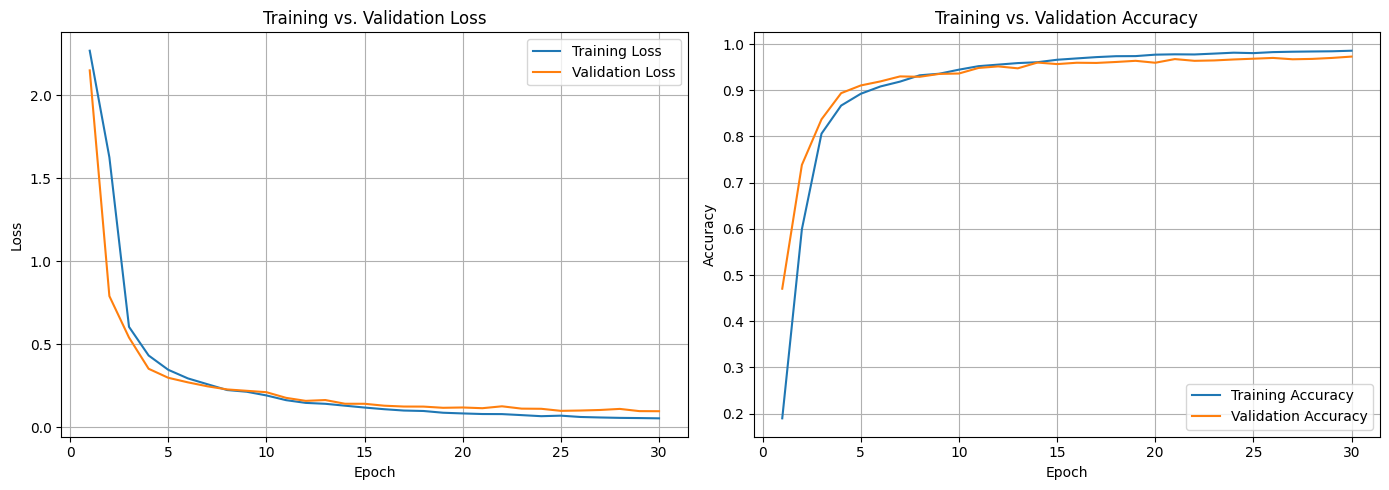

In [31]:
plot_training_results(res_dict_cnn)